In [1]:
import os
import autophot as ap
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from time import time
from photutils.segmentation import detect_sources
import glob as glob

import pandas as pd
%matplotlib inline

/Users/olivermuller/.conda/envs/autophot-custom/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load Dragonfly profiles for the comparison

#### be aware to set the band yourself: either g or r

In [2]:
band="g"
dragonfly_profiles=[]
for file in glob.glob(f"./dragonfly_profiles/*{band}.txt"):
    dragonfly_profile_df=pd.read_csv(file,names=["r","sb"])
    dragonfly_profiles.append(dragonfly_profile_df)

## load the fits file

In [3]:
#name="30keV_SDSSg_CCD273-84_35Mpc_EOfull"
name="30keV_SDSSg_CCD273-84_35Mpc_FOfull"
#name="30keV_SDSSr_CCD273-84_35Mpc_EOfull"
#name="30keV_SDSSr_CCD273-84_35Mpc_FOfull"
path="/Users/olivermuller/Data/ARRAKIHS_mocks/TORREY_SIMULATIONS_SDSS/"
hdu = fits.open(f"{path}{name}.fits")
target_data = np.array(10**(-hdu[0].data/2.5), dtype = np.float64)



## get the pixel scale of the fits file

In [4]:
XMAX=hdu[0].header["XMAX"]
XMIN=hdu[0].header["XMIN"]
NX=hdu[0].header["NX"]
pixelscale=(XMAX-XMIN)/NX
print(f"pixelscale is {pixelscale}")

pixelscale is 1.674821535067083


## Produce a mask via photutils

#### note that currently, the central object is removed from the mask. This is handcrafted.

In [5]:
######################################### 
# NOTE: photutils is not a dependency of AutoPhot, make sure you run: pip install photutils
# if you dont already have that package. Also note that you can use any segmentation map
# code, we just use photutils here because it is very easy.
#########################################
segmap = detect_sources(target_data, threshold = 10**(-30/2.5), npixels = 100) # threshold and npixels determined just by playing around with the values
central_index=segmap.data[1700,1700]
segmap.data[segmap.data==central_index]=0
mask=segmap.data

## Set the target which includes the mask

In [6]:
# Create a target object with specified pixelscale and zeropoint
target = ap.image.Target_Image(
    data = target_data,
    mask=mask,
    pixelscale = pixelscale, # Every target image needs to know it's pixelscale in arcsec/pixel
    zeropoint = 0, # optionally, you can give a zeropoint to tell AutoPhot what the pixel flux units are
    variance = np.ones(target_data.shape)/1e3, # set the variance for this image (in general it should be more accurate than this)
)

# The default AutoPhot target plotting method uses log scaling in bright areas and histogram scaling in faint areas
fig3, ax3 = plt.subplots(figsize = (8,8))
ap.plots.target_image(fig3, ax3, target)
plt.show()

## we now generate the model. However, for the purpose of the radial profile, we do not actually use it.

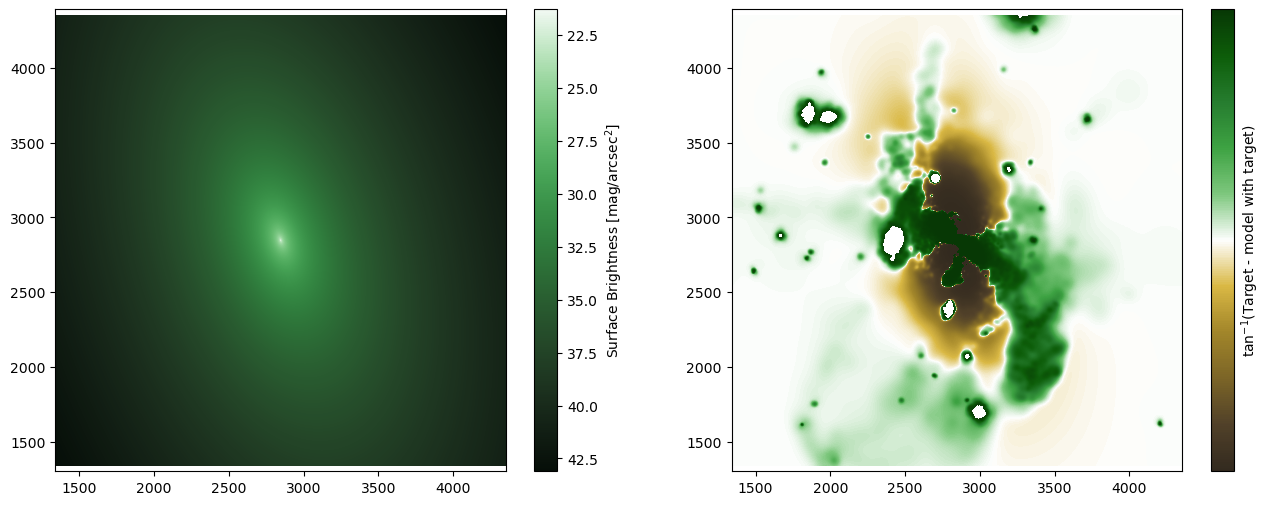

In [7]:
# This model now has a target that it will attempt to match
model2 = ap.models.AutoPhot_Model(
    name = "model with target", 
    window=[[800,2600],[800,2600]],
    model_type = "sersic galaxy model", # feel free to swap out sersic with other profile types
    target = target, # now the model knows what its trying to match
)

# Instead of giving initial values for all the parameters, it is possible to simply call "initialize" and AutoPhot 
# will try to guess initial values for every parameter assuming the galaxy is roughly centered. It is also possible
# to set just a few parameters and let AutoPhot try to figure out the rest. For example you could give it an initial
# Guess for the center and it will work from there.
model2.initialize()

# Plotting the initial parameters and residuals, we see it gets the rough shape of the galaxy right, but still has some fitting to do
fig4, ax4 = plt.subplots(1, 2, figsize = (16,6))
ap.plots.model_image(fig4, ax4[0], model2)
ap.plots.residual_image(fig4, ax4[1], model2)
plt.show()

## Plot the SB profile. Note that we are not using the model, but are creating the SB profile from the data!

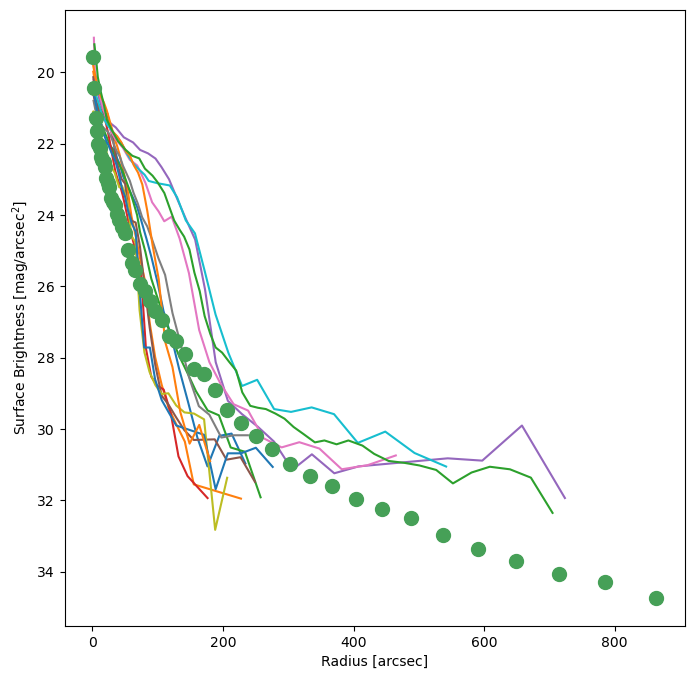

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot surface brightness profile

# we now plot the model profile and a data profile. The model profile is determined from the model parameters
# the data profile is determined by taking the median of pixel values at a given radius. Notice that the model
# profile is slightly higher than the data profile? This is because there are other objects in the image which
# are not being modelled, the data profile uses a median so they are ignored, but for the model we fit all pixels.
fig10, ax10 = plt.subplots(figsize = (8,8))

for profile_df in dragonfly_profiles:
    plt.plot(np.rad2deg(np.arctan(profile_df["r"]/35000))*3600,profile_df["sb"])


#ap.plots.galaxy_light_profile(fig10, ax10, model2) # this would plot the SB profile of the model
Rbins, stat, scat, count= ap.plots.radial_median_profile(fig10, ax10, model2,return_profile=True,plot_kwargs={"ms":20}) #
Rbins_mid=[]
bin_size=Rbins[1]-Rbins[0]
for i in np.arange(0,len(Rbins)-1):
    Rbins_mid.append(Rbins[i]+bin_size/2)
Rbins_mid=np.array(Rbins_mid)
profile_df=pd.DataFrame(np.array([Rbins_mid, stat]).T,columns=["bin_mid_arcsec","SB"])
profile_df.to_csv(f"{path}{name}_profile.csv", index=False)

plt.show()

plt.tight_layout()
plt.savefig(f'./{name}_SB_profile.pdf', format='pdf',bbox_inches="tight")